In [ ]:
import os
import zarr
from config import DATA_DIR
import numpy as np
from typing import Dict, Any

def process_experiment_runs(base_dir: str) -> Dict[str, Dict[str, Dict[str, Any]]]:
    data_results: Dict[str, Dict[str, Dict[str, Any]]] = {}

    for ts_folder in os.listdir(base_dir):
        ts_path = os.path.join(base_dir, ts_folder)
        zarr_path = os.path.join(ts_path, "VoxelSpacing10.000/denoised.zarr")

        if os.path.exists(zarr_path):
            print(f"Processing {ts_folder}...")

            zgroup = zarr.open_group(zarr_path, mode='r')

            print(f"Tree structure for {ts_folder}:")
            print(zgroup.tree())

            ts_data: Dict[str, Dict[str, Any]] = {}

            for subgroup_key in zgroup.keys():
                subgroup = zgroup[subgroup_key]
                ts_data[subgroup_key] = {
                    "attrs": dict(subgroup.attrs),
                    "info": subgroup.info,
                    "data": subgroup[:],
                }

            data_results[ts_folder] = ts_data

    return data_results

all_data = process_experiment_runs(DATA_DIR)

print("Processing complete. Summary of extracted data:")
for ts_name, ts_content in all_data.items():
    print(f"- {ts_name}: {len(ts_content)} subgroups processed.")


Processing TS_5_4...
Tree structure for TS_5_4:


/
├── 0 (184, 630, 630) float32
├── 1 (92, 315, 315) float32
└── 2 (46, 158, 158) float32


Processing TS_6_4...
Tree structure for TS_6_4:


/
├── 0 (184, 630, 630) float32
├── 1 (92, 315, 315) float32
└── 2 (46, 158, 158) float32


Processing TS_99_9...
Tree structure for TS_99_9:


/
├── 0 (184, 630, 630) float32
├── 1 (92, 315, 315) float32
└── 2 (46, 158, 158) float32


Processing TS_86_3...
Tree structure for TS_86_3:


/
├── 0 (184, 630, 630) float32
├── 1 (92, 315, 315) float32
└── 2 (46, 158, 158) float32


Processing TS_69_2...
Tree structure for TS_69_2:


/
├── 0 (184, 630, 630) float32
├── 1 (92, 315, 315) float32
└── 2 (46, 158, 158) float32


Processing TS_73_6...
Tree structure for TS_73_6:


/
├── 0 (184, 630, 630) float32
├── 1 (92, 315, 315) float32
└── 2 (46, 158, 158) float32


Processing TS_6_6...
Tree structure for TS_6_6:


/
├── 0 (184, 630, 630) float32
├── 1 (92, 315, 315) float32
└── 2 (46, 158, 158) float32


Processing complete. Summary of extracted data:
- TS_5_4: 3 subgroups processed.
- TS_6_4: 3 subgroups processed.
- TS_99_9: 3 subgroups processed.
- TS_86_3: 3 subgroups processed.
- TS_69_2: 3 subgroups processed.
- TS_73_6: 3 subgroups processed.
- TS_6_6: 3 subgroups processed.


Résumé des données de targets :
- TS_5_4: 6 molécules trouvées
  * thyroglobulin: 30 points
  * virus-like-particle: 11 points
  * beta-galactosidase: 12 points
  * ribosome: 31 points
  * apo-ferritin: 46 points
  * beta-amylase: 10 points
- TS_6_4: 6 molécules trouvées
  * thyroglobulin: 30 points
  * virus-like-particle: 10 points
  * beta-galactosidase: 12 points
  * ribosome: 74 points
  * apo-ferritin: 58 points
  * beta-amylase: 9 points
- TS_99_9: 6 molécules trouvées
  * thyroglobulin: 49 points
  * virus-like-particle: 13 points
  * beta-galactosidase: 24 points
  * ribosome: 65 points
  * apo-ferritin: 36 points
  * beta-amylase: 21 points
- TS_86_3: 6 molécules trouvées
  * thyroglobulin: 45 points
  * virus-like-particle: 29 points
  * beta-galactosidase: 23 points
  * ribosome: 55 points
  * apo-ferritin: 64 points
  * beta-amylase: 9 points
- TS_69_2: 6 molécules trouvées
  * thyroglobulin: 34 points
  * virus-like-particle: 9 points
  * beta-galactosidase: 16 points
  *

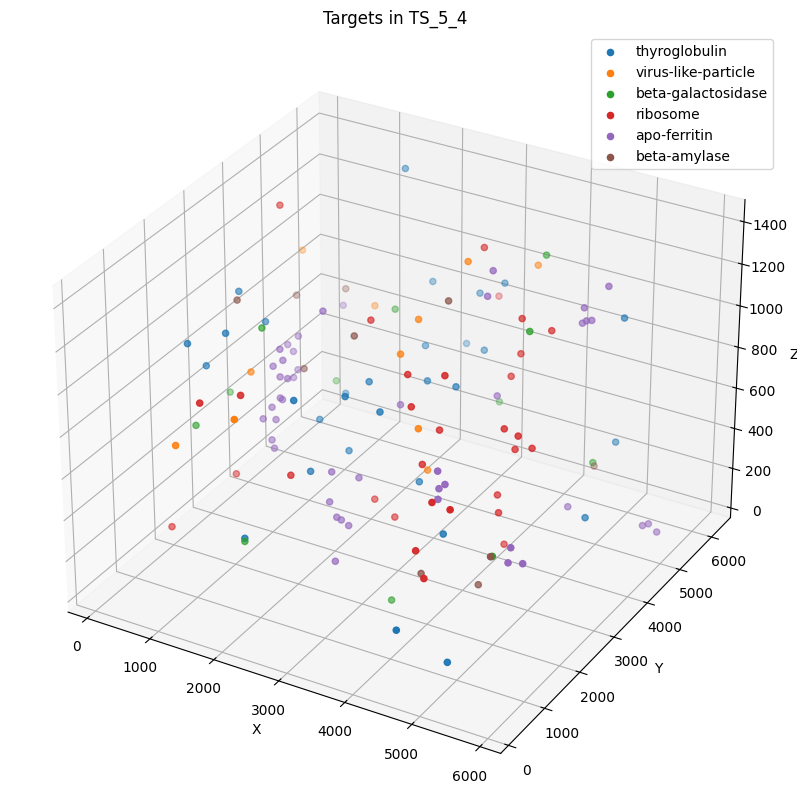

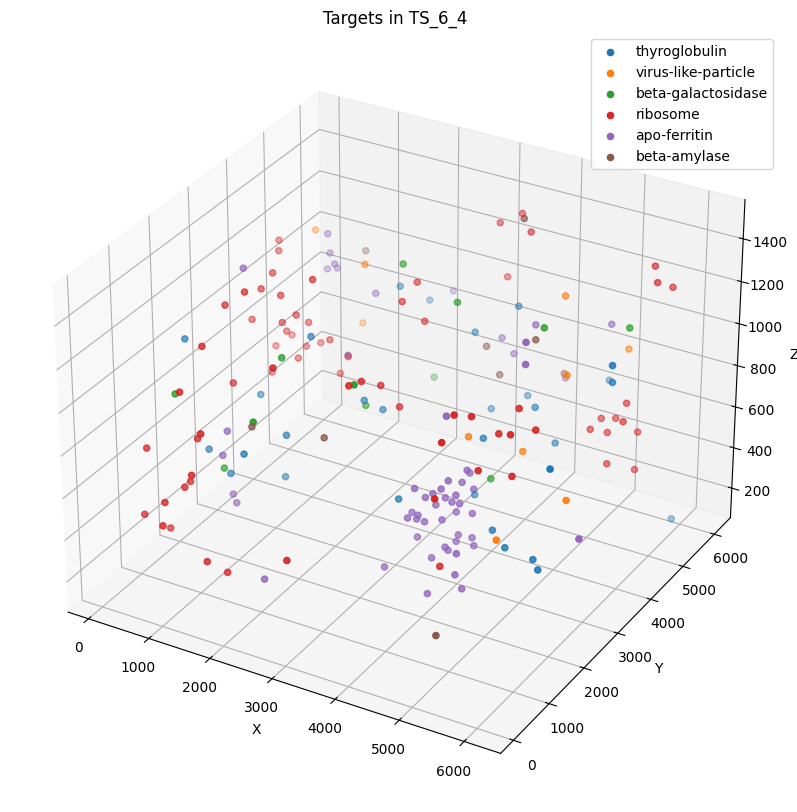

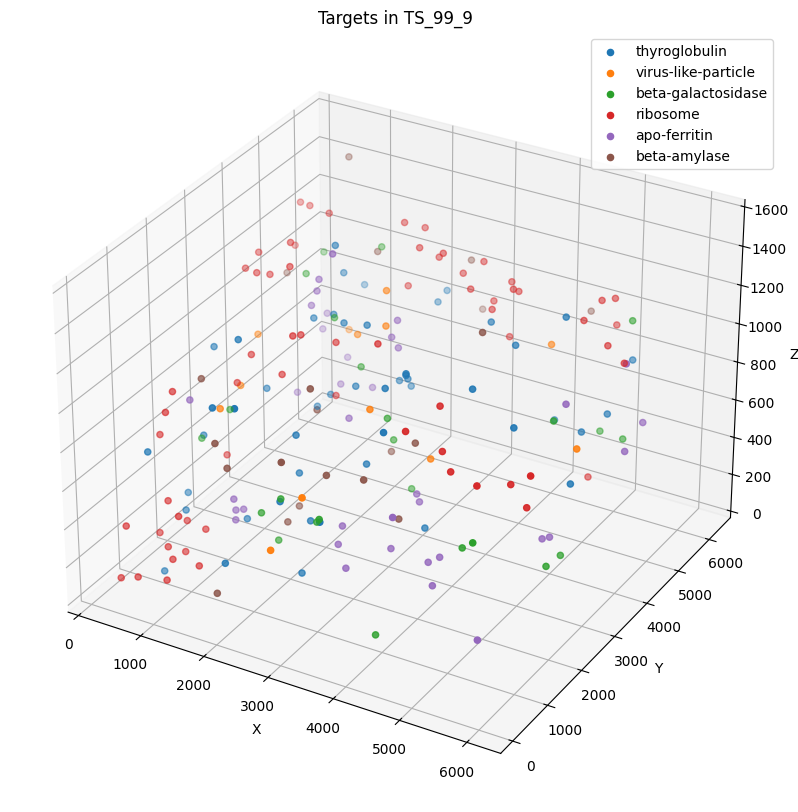

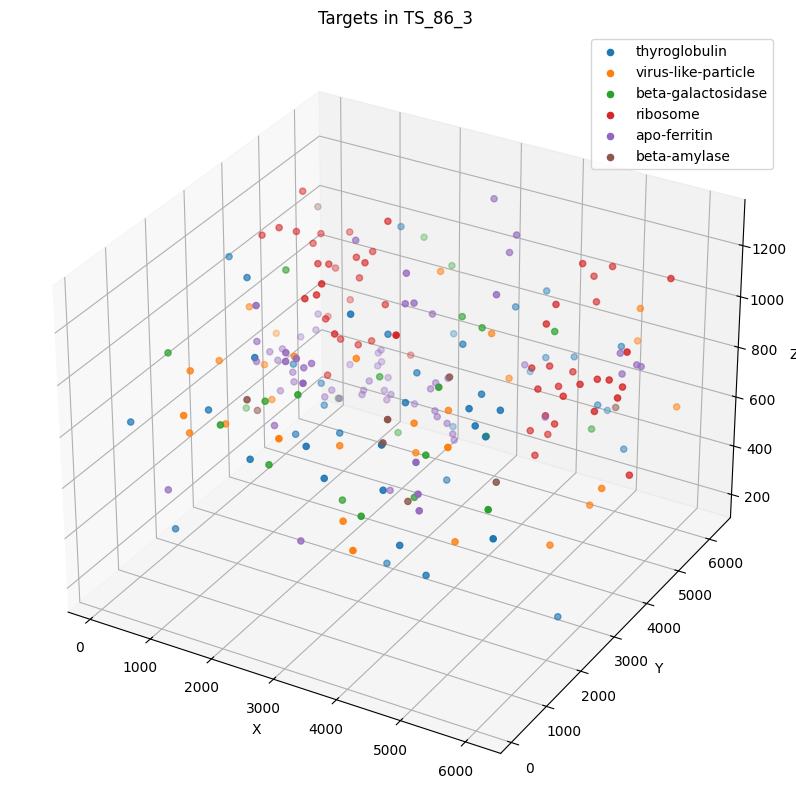

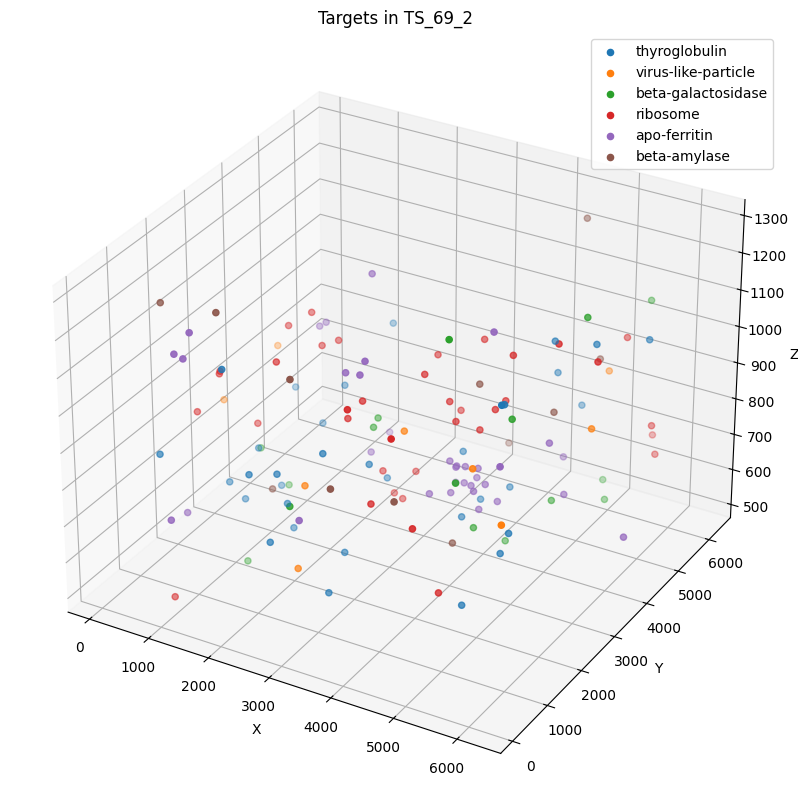

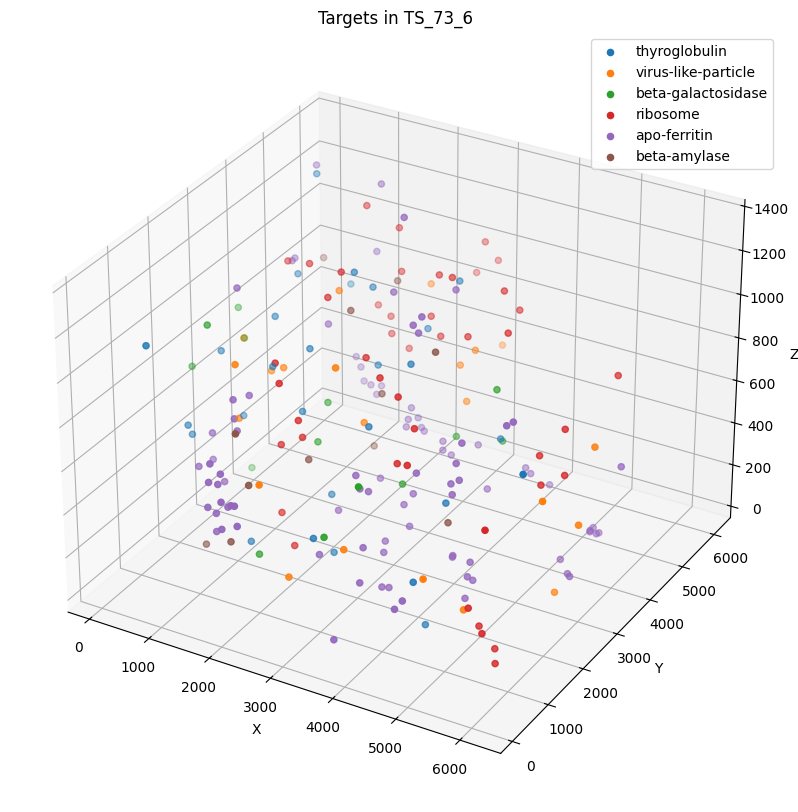

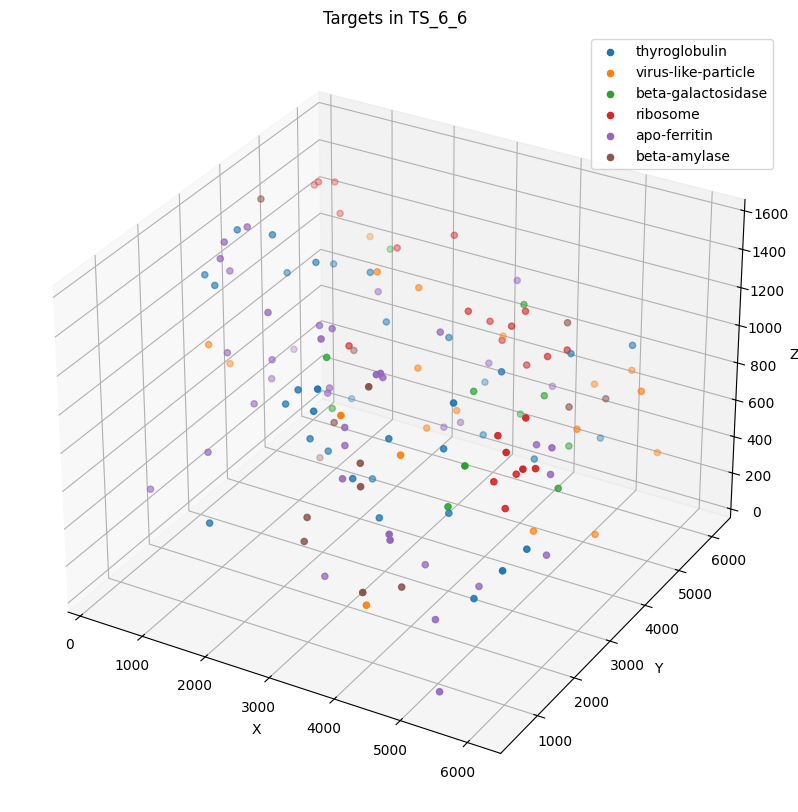

In [ ]:
import json
import os
from typing import Dict, List, Any
import numpy as np
import matplotlib.pyplot as plt

def load_targets(base_path: str) -> Dict[str, Dict[str, List[List[float]]]]:
    target_data: Dict[str, Dict[str, List[List[float]]]] = {}

    for tomogram_folder in os.listdir(base_path):
        tomogram_path = os.path.join(base_path, tomogram_folder)
        picks_path = os.path.join(tomogram_path, "Picks")

        if not os.path.exists(picks_path):
            print(f"Pas de dossier 'Picks' dans {tomogram_folder}")
            continue

        for json_file in os.listdir(picks_path):
            if json_file.endswith(".json"):
                json_path = os.path.join(picks_path, json_file)

                with open(json_path, 'r') as f:
                    data = json.load(f)

                molecule_name: str = data.get("pickable_object_name", "inconnu")
                points: List[Any] = data.get("points", [])

                formatted_points: List[List[float]] = []
                for point in points:
                    if isinstance(point, dict) and 'location' in point:
                        location = point['location']
                        formatted_points.append([location['x'], location['y'], location['z']])
                    else:
                        print(f"Skipping invalid point format in {molecule_name} of {tomogram_folder}: {point}")

                if tomogram_folder not in target_data:
                    target_data[tomogram_folder] = {}

                target_data[tomogram_folder][molecule_name] = formatted_points

    return target_data

def show_targets(target_data: Dict[str, Dict[str, List[List[float]]]]) -> None:
    for tomogram, molecules in target_data.items():
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')
        ax.set_title(f'Targets in {tomogram}')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

        for molecule, points in molecules.items():
            points = np.array(points)
            if points.ndim == 2 and points.shape[1] == 3:
                ax.scatter(points[:, 0], points[:, 1], points[:, 2], label=molecule)
            else:
                print(f"Skipping {molecule} in {tomogram} due to incorrect shape: {points.shape}")

        ax.legend()
        plt.show()

all_targets = load_targets(TARGET_DIR)

print("Résumé des données de targets :")
for tomogram, molecules in all_targets.items():
    print(f"- {tomogram}: {len(molecules)} molécules trouvées")
    for molecule, points in molecules.items():
        print(f"  * {molecule}: {len(points)} points")

show_targets(all_targets)

In [ ]:
import os
from typing import Dict, List

def display_protein_locations(
    tomogram_path: str,
    slice_index: int,
    target_data: Dict[str, Dict[str, List[List[float]]]],
    z_tolerance: int = 5
) -> None:
    tomogram_name = os.path.basename(os.path.dirname(os.path.dirname(tomogram_path)))
    print(f"\nAnalyzing slice {slice_index} of tomogram {tomogram_name}")
    print("-" * 80)
    
    if tomogram_name in target_data:
        print(f"{'Protein Type':<20} {'X':>10} {'Y':>10} {'Z':>10}")
        print("-" * 80)
        
        for molecule, points in target_data[tomogram_name].items():
            points_found = False
            
            for point in points:
                x, y, z = point
                if abs(float(z) - slice_index) <= z_tolerance:
                    points_found = True
                    print(f"{molecule:<20} {x:10.2f} {y:10.2f} {z:10.2f}")
            
            if not points_found:
                print(f"No {molecule} found in slice {slice_index} (±{z_tolerance})")
        
        print("-" * 80)
    else:
        print(f"No data found for tomogram {tomogram_name}")
        print(f"Available tomograms: {list(target_data.keys())}")

tomogram_path = os.path.join(DATA_DIR, 'TS_5_4/VoxelSpacing10.000/denoised.zarr')
slice_index = 300
display_protein_locations(tomogram_path, slice_index, all_targets, z_tolerance=100)



Analyzing slice 300 of tomogram TS_5_4
--------------------------------------------------------------------------------
Protein Type                  X          Y          Z
--------------------------------------------------------------------------------
thyroglobulin           4527.71     221.47     279.91
thyroglobulin           5458.27    3743.42     332.07
virus-like-particle     3137.40    3572.46     372.91
beta-galactosidase      1959.18     701.50     371.23
ribosome                 691.64     897.38     288.35
ribosome                 948.22    2155.29     372.13
ribosome                2803.20    2701.11     336.10
ribosome                3189.68    2565.63     306.80
ribosome                4632.09    2990.23     244.14
apo-ferritin            1072.45    2963.26     384.01
apo-ferritin            4829.39    4473.38     208.71
apo-ferritin            2801.72    1630.41     204.47
apo-ferritin            2504.12    2311.85     267.45
apo-ferritin            2499.28    2197.39

In [ ]:
import os
import zarr
from typing import Dict, List

def display_protein_locations(
    tomogram_path: str,
    slice_index: int,
    target_data: Dict[str, Dict[str, List[List[float]]]],
    z_tolerance: int = 5
) -> None:
    zgroup = zarr.open_group(tomogram_path, mode='r')
    tomogram_data = zgroup['0']
    z_dim, y_dim, x_dim = tomogram_data.shape
    
    print(f"\nValid slice range: 0 to {z_dim-1}")
    if slice_index < 0 or slice_index >= z_dim:
        print(f"WARNING: slice_index {slice_index} is out of valid range!")
    
    tomogram_name = os.path.basename(os.path.dirname(os.path.dirname(tomogram_path)))
    print(f"\nAnalyzing slice {slice_index} of tomogram {tomogram_name}")
    print("-" * 80)
    
    if tomogram_name in target_data:
        print(f"{'Protein Type':<20} {'X':>10} {'Y':>10} {'Z':>10}")
        print("-" * 80)
        
        for molecule, points in target_data[tomogram_name].items():
            points_found = False
            
            x_coords = [p[0] for p in points]
            y_coords = [p[1] for p in points]
            z_coords = [p[2] for p in points]
            
            x_scale = x_dim / max(x_coords)
            y_scale = y_dim / max(y_coords)
            z_scale = z_dim / max(z_coords)
            
            for point in points:
                x, y, z = point
                x_scaled = x * x_scale
                y_scaled = y * y_scale
                z_scaled = z * z_scale
                
                if abs(z_scaled - slice_index) <= z_tolerance:
                    points_found = True
                    print(f"{molecule:<20} {x_scaled:10.2f} {y_scaled:10.2f} {z_scaled:10.2f}")
            
            if not points_found:
                print(f"No {molecule} found in slice {slice_index} (±{z_tolerance})")
        
        print("-" * 80)
    else:
        print(f"No data found for tomogram {tomogram_name}")
        print(f"Available tomograms: {list(target_data.keys())}")

tomogram_path = os.path.join(DATA_DIR, 'TS_5_4/VoxelSpacing10.000/denoised.zarr')

print("Testing different slice indices:")
for slice_index in [0, 50, 183, 184, 200]:
    print(f"\nTesting slice_index = {slice_index}")
    display_protein_locations(tomogram_path, slice_index, all_targets)


Testing different slice indices:

Testing slice_index = 0

Valid slice range: 0 to 183

Analyzing slice 0 of tomogram TS_5_4
--------------------------------------------------------------------------------
Protein Type                  X          Y          Z
--------------------------------------------------------------------------------
No thyroglobulin found in slice 0 (±5)
No virus-like-particle found in slice 0 (±5)
No beta-galactosidase found in slice 0 (±5)
No ribosome found in slice 0 (±5)
No apo-ferritin found in slice 0 (±5)
No beta-amylase found in slice 0 (±5)
--------------------------------------------------------------------------------

Testing slice_index = 50

Valid slice range: 0 to 183

Analyzing slice 50 of tomogram TS_5_4
--------------------------------------------------------------------------------
Protein Type                  X          Y          Z
--------------------------------------------------------------------------------
thyroglobulin            587.0

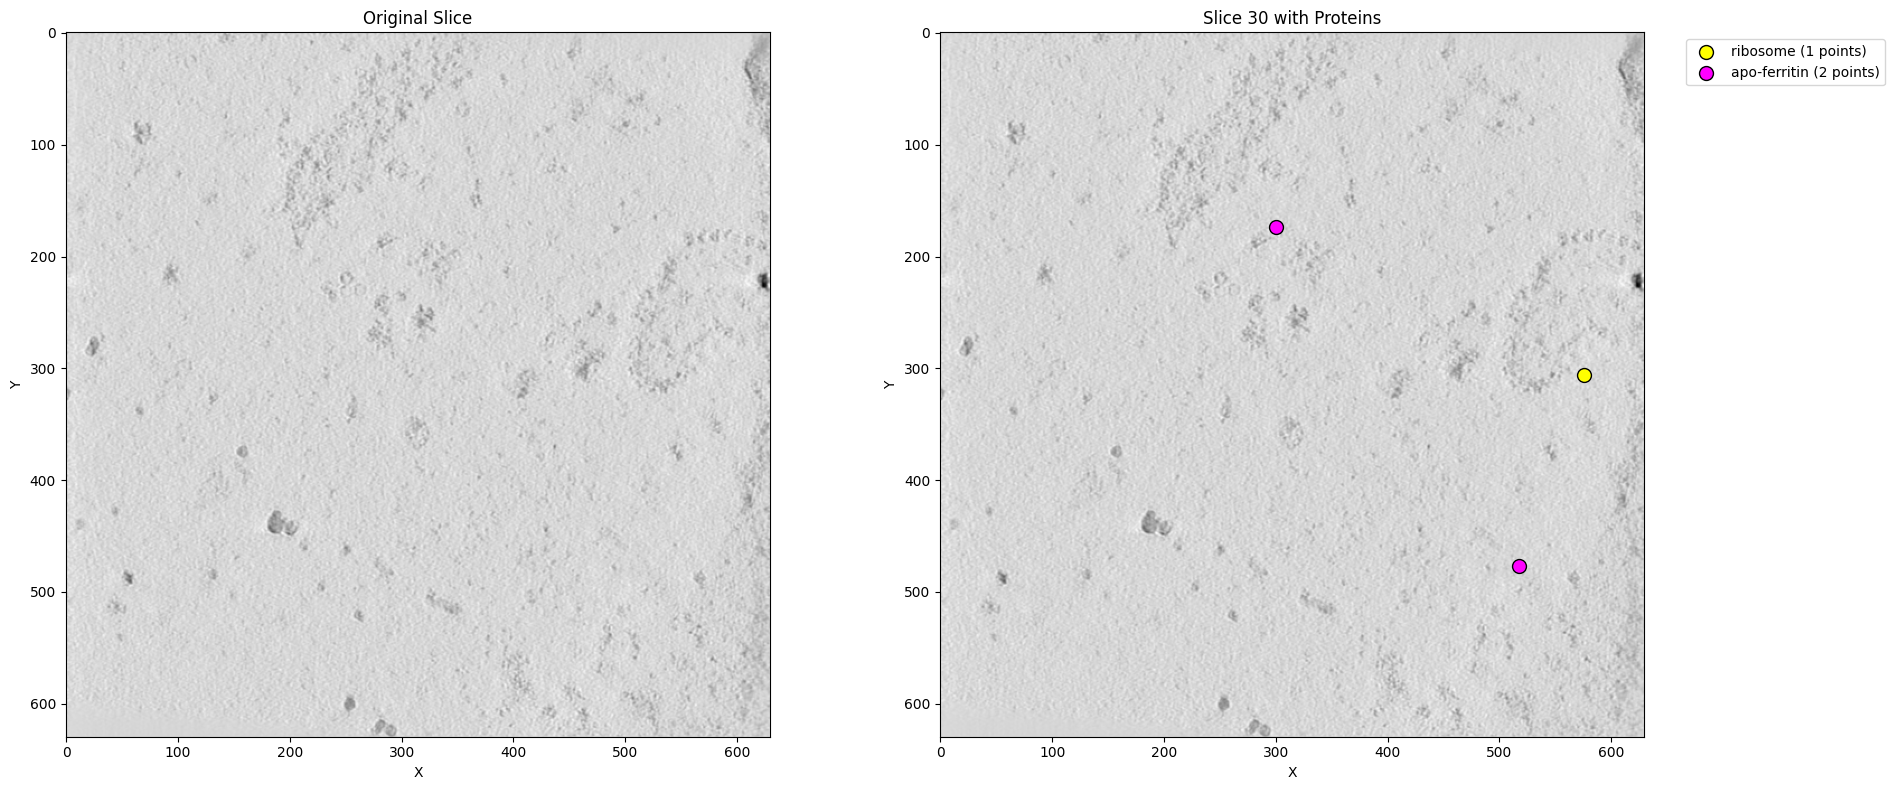

In [ ]:
import os
import zarr
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List

def visualize_2d_slice_with_protein(
    tomogram_path: str, 
    slice_index: int, 
    target_data: Dict[str, Dict[str, List[List[float]]]],
    z_tolerance: int = 5
) -> None:
    protein_colors = {
        'thyroglobulin': 'red',
        'virus-like-particle': 'lime',
        'beta-galactosidase': 'blue',
        'ribosome': 'yellow',
        'apo-ferritin': 'magenta',
        'beta-amylase': 'cyan'
    }

    zgroup = zarr.open_group(tomogram_path, mode='r')
    tomogram_data = zgroup['0']
    z_dim, y_dim, x_dim = tomogram_data.shape

    if slice_index < 0 or slice_index >= z_dim:
        raise ValueError(f"slice_index must be between 0 and {z_dim-1}")

    slice_data = tomogram_data[slice_index, :, :]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    ax1.imshow(slice_data, cmap='gray')
    ax1.set_title('Original Slice')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')

    ax2.imshow(slice_data, cmap='gray')
    ax2.set_title(f'Slice {slice_index} with Proteins')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')

    tomogram_name = os.path.basename(os.path.dirname(os.path.dirname(tomogram_path)))
    
    if tomogram_name in target_data:
        for molecule, points in target_data[tomogram_name].items():
            if points:
                x_coords = [p[0] for p in points]
                y_coords = [p[1] for p in points]
                z_coords = [p[2] for p in points]
                
                x_scale = x_dim / max(x_coords)
                y_scale = y_dim / max(y_coords)
                z_scale = z_dim / max(z_coords)

                scaled_x = []
                scaled_y = []
                
                for point in points:
                    x, y, z = point
                    z_scaled = z * z_scale
                    
                    if abs(z_scaled - slice_index) <= z_tolerance:
                        scaled_x.append(x * x_scale)
                        scaled_y.append(y * y_scale)
                
                if scaled_x and scaled_y:
                    color = protein_colors.get(molecule, 'white')
                    ax2.scatter(scaled_x, scaled_y, 
                              c=color,
                              s=100,
                              label=f"{molecule} ({len(scaled_x)} points)",
                              marker='o',
                              edgecolors='black',
                              linewidths=1,
                              alpha=1)

    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

tomogram_path = os.path.join(DATA_DIR, 'TS_5_4/VoxelSpacing10.000/denoised.zarr')
slice_index = 30
visualize_2d_slice_with_protein(tomogram_path, slice_index, all_targets)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import zarr
import os
from typing import Dict, List, Tuple, Optional
from pathlib import Path
import logging

def create_label_volume(
    shape: Tuple[int, int, int],
    protein_points: Dict[str, List[List[float]]],
    protein_classes: Dict[str, int]
) -> np.ndarray:
    z_dim, y_dim, x_dim = shape
    label_volume = np.zeros((z_dim, y_dim, x_dim, 7), dtype=np.float32)
    
    for molecule, points in protein_points.items():
        if molecule in protein_classes:
            class_idx = protein_classes[molecule]
            x_coords = [p[0] for p in points]
            y_coords = [p[1] for p in points]
            z_coords = [p[2] for p in points]
       
            x_scale = x_dim / max(x_coords)
            y_scale = y_dim / max(y_coords)
            z_scale = z_dim / max(z_coords)
            
            for point in points:
                z = int(point[2] * z_scale)
                y = int(point[1] * y_scale)
                x = int(point[0] * x_scale)
                
                if (0 <= z < z_dim and 0 <= y < y_dim and 0 <= x < x_dim):
                    sigma = 3
                    z_idx, y_idx, x_idx = np.ogrid[
                        max(0, z-sigma):min(z_dim, z+sigma+1),
                        max(0, y-sigma):min(y_dim, y+sigma+1),
                        max(0, x-sigma):min(x_dim, x+sigma+1)
                    ]
                    
                    dist = ((z_idx - z)**2 + (y_idx - y)**2 + (x_idx - x)**2)
                    mask = np.exp(-dist / (2 * sigma**2))
                    
                    label_volume[
                        z_idx, y_idx, x_idx, class_idx
                    ] = np.maximum(
                        label_volume[z_idx, y_idx, x_idx, class_idx],
                        mask
                    )
    
    label_volume[..., 6] = 1 - np.max(label_volume[..., :6], axis=-1)
    return label_volume

class AttentionBlock(nn.Module):
    def __init__(self, in_channels: int) -> None:
        super().__init__()
        self.attention = nn.Sequential(
            nn.Conv3d(in_channels, in_channels, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x * self.attention(x)
    
class UNet3D(nn.Module):
    def __init__(self, in_channels: int = 1, out_channels: int = 7) -> None:
        super().__init__()
        
        # Encoder
        self.enc1 = self._conv_block(in_channels, 64)
        self.enc2 = self._conv_block(64, 128)
        self.enc3 = self._conv_block(128, 256)
        
        self.bottleneck = self._conv_block(256, 512)
        
        # Decoder
        self.dec3 = self._conv_block(512 + 256, 256)
        self.dec2 = self._conv_block(256 + 128, 128)
        self.dec1 = self._conv_block(128 + 64, 64)
        
        self.final = nn.Conv3d(64, out_channels, kernel_size=1)
        self.pool = nn.MaxPool3d(2)

        self.attention1 = AttentionBlock(64)
        self.attention2 = AttentionBlock(128)
        self.attention3 = AttentionBlock(256)

        self.dropout = nn.Dropout3d(0.3)
        
    def _conv_block(self, in_ch: int, out_ch: int) -> nn.Sequential:
        return nn.Sequential(
            nn.Conv3d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        e1 = self.attention1(self.enc1(x))
        e2 = self.attention2(self.enc2(self.pool(e1)))
        e3 = self.attention3(self.enc3(self.pool(e2)))
        
        e3 = self.dropout(e3)

        b = self.bottleneck(self.pool(e3))

        d3 = self.dec3(torch.cat([F.interpolate(b, e3.shape[2:]), e3], dim=1))
        d2 = self.dec2(torch.cat([F.interpolate(d3, e2.shape[2:]), e2], dim=1))
        d1 = self.dec1(torch.cat([F.interpolate(d2, e1.shape[2:]), e1], dim=1))
        
        return torch.softmax(self.final(d1), dim=1)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import zarr
from pathlib import Path
import logging
from typing import Dict, List, Tuple
from tqdm import tqdm

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

Path("best_model").mkdir(exist_ok=True)

protein_classes = {
    'thyroglobulin': 0,
    'virus-like-particle': 1,
    'beta-galactosidase': 2,
    'ribosome': 3,
    'apo-ferritin': 4,
    'beta-amylase': 5
}

def process_chunk(
    tomogram: np.ndarray,
    chunk_size: Tuple[int, int, int] = (64, 64, 64),
    overlap: int = 16
) -> List[Tuple[np.ndarray, Tuple[int, int, int]]]:
    z, y, x = tomogram.shape
    chunks = []
    
    for zi in range(0, z - chunk_size[0] + overlap, chunk_size[0] - overlap):
        for yi in range(0, y - chunk_size[1] + overlap, chunk_size[1] - overlap):
            for xi in range(0, x - chunk_size[2] + overlap, chunk_size[2] - overlap):
                chunk = tomogram[
                    zi:zi+chunk_size[0],
                    yi:yi+chunk_size[1],
                    xi:xi+chunk_size[2]
                ]
                if chunk.shape == chunk_size:
                    chunks.append((chunk, (zi, yi, xi)))
    
    return chunks

def weighted_cross_entropy_loss(
    output: torch.Tensor,
    target: torch.Tensor,
    num_classes: int = 7
) -> torch.Tensor:
    epsilon = 1e-8 
    target_flat = target.view(-1)
    class_counts = torch.bincount(target_flat, minlength=num_classes).float()
    total_samples = class_counts.sum()
    
    class_weights = total_samples / (class_counts + epsilon)
    class_weights = class_weights / class_weights.sum()
    class_weights = class_weights.to(output.device)
    
    return F.cross_entropy(output, target, weight=class_weights)

def train_epoch(
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    tomogram: np.ndarray,
    labels: np.ndarray,
    device: torch.device,
    chunk_size: Tuple[int, int, int] = (64, 64, 64)
) -> float:
    model.train()
    total_loss = 0
    chunks = process_chunk(tomogram, chunk_size)
    chunks_processed = 0
    
    for chunk, (zi, yi, xi) in tqdm(chunks, desc="Training chunks"):
        chunk_tensor = torch.from_numpy(chunk).float().unsqueeze(0).unsqueeze(0).to(device)
        
        label_chunk = labels[
            zi:zi+chunk_size[0],
            yi:yi+chunk_size[1],
            xi:xi+chunk_size[2]
        ]
        
        if np.any(label_chunk[..., :-1] > 0): 
            label_tensor = torch.from_numpy(label_chunk).argmax(dim=-1).unsqueeze(0).to(device)
            
            optimizer.zero_grad()
            output = model(chunk_tensor)
            
            loss = weighted_cross_entropy_loss(output, label_tensor)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            chunks_processed += 1
    
    return total_loss / max(chunks_processed, 1) 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {device}")

model = UNet3D().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
best_loss = float('inf')

train_tomograms = [
    'data/raw/train/static/ExperimentRuns/TS_5_4/VoxelSpacing10.000/denoised.zarr',
    'data/raw/train/static/ExperimentRuns/TS_6_4/VoxelSpacing10.000/denoised.zarr'
]

num_epochs = 50
best_loss = float('inf')
patience = 10
patience_counter = 0

for epoch in range(num_epochs):
    epoch_total_loss = 0
    num_tomograms = 0
    
    for tomogram_path in train_tomograms:
        zgroup = zarr.open_group(tomogram_path, mode='r')
        tomogram_data = zgroup['0'][:]
        tomogram_name = Path(tomogram_path).parent.parent.name
        
        if tomogram_name in all_targets:
            label_volume = create_label_volume(
                tomogram_data.shape,
                all_targets[tomogram_name],
                protein_classes
            )
            
            epoch_loss = train_epoch(model, optimizer, tomogram_data, label_volume, device)
            epoch_total_loss += epoch_loss
            num_tomograms += 1
            
            logger.info(f"Epoch {epoch}, Tomogram {tomogram_name}, Loss: {epoch_loss:.4f}")
    
    avg_epoch_loss = epoch_total_loss / num_tomograms
    logger.info(f"Epoch {epoch}, Average Loss: {avg_epoch_loss:.4f}")
    
    if avg_epoch_loss < best_loss:
        best_loss = avg_epoch_loss
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_loss,
        }, 'best_model/best_model.pth')
        logger.info(f"Saved new best model with loss: {best_loss:.4f}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            logger.info(f"Early stopping triggered after {epoch + 1} epochs")
            break

logger.info("Training completed!")

INFO:__main__:Using device: cuda


Training chunks: 100%|██████████| 432/432 [00:55<00:00,  7.74it/s]
INFO:__main__:Epoch 0, Tomogram TS_5_4, Loss: 1.8546
Training chunks: 100%|██████████| 432/432 [00:51<00:00,  8.36it/s]
INFO:__main__:Epoch 0, Tomogram TS_6_4, Loss: 1.8081
INFO:__main__:Epoch 0, Average Loss: 1.8313
INFO:__main__:Saved new best model with loss: 1.8313
Training chunks: 100%|██████████| 432/432 [00:50<00:00,  8.54it/s]
INFO:__main__:Epoch 1, Tomogram TS_5_4, Loss: 1.7723
Training chunks: 100%|██████████| 432/432 [00:51<00:00,  8.39it/s]
INFO:__main__:Epoch 1, Tomogram TS_6_4, Loss: 1.7322
INFO:__main__:Epoch 1, Average Loss: 1.7523
INFO:__main__:Saved new best model with loss: 1.7523
Training chunks: 100%|██████████| 432/432 [00:50<00:00,  8.52it/s]
INFO:__main__:Epoch 2, Tomogram TS_5_4, Loss: 1.7075
Training chunks: 100%|██████████| 432/432 [00:51<00:00,  8.39it/s]
INFO:__main__:Epoch 2, Tomogram TS_6_4, Loss: 1.7039
INFO:__main__:Epoch 2, Average Loss: 1.7057
INFO:__main__:Saved new best model with lo

KeyboardInterrupt: 

In [ ]:
import torch
import numpy as np
import zarr
from pathlib import Path
from typing import Dict, List, Tuple, Optional
import logging
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

def process_chunk(
    tomogram: np.ndarray,
    chunk_size: Tuple[int, int, int] = (64, 64, 64),
    overlap: int = 16
) -> List[Tuple[np.ndarray, Tuple[int, int, int]]]:
    z, y, x = tomogram.shape
    chunks = []
    
    total_chunks = ((z - chunk_size[0]) // (chunk_size[0] - overlap) + 1) * \
                   ((y - chunk_size[1]) // (chunk_size[1] - overlap) + 1) * \
                   ((x - chunk_size[2]) // (chunk_size[2] - overlap) + 1)
    
    with tqdm(total=total_chunks, desc="Generating chunks") as pbar:
        for zi in range(0, z - chunk_size[0] + overlap, chunk_size[0] - overlap):
            for yi in range(0, y - chunk_size[1] + overlap, chunk_size[1] - overlap):
                for xi in range(0, x - chunk_size[2] + overlap, chunk_size[2] - overlap):
                    chunk = tomogram[
                        zi:zi+chunk_size[0],
                        yi:yi+chunk_size[1],
                        xi:xi+chunk_size[2]
                    ]
                    if chunk.shape == chunk_size:
                        chunks.append((chunk, (zi, yi, xi)))
                    pbar.update(1)
    
    return chunks

def evaluate_model(
    model_path: str,
    test_tomogram_path: str,
    target_data: Dict[str, Dict[str, List[List[float]]]],
    device: torch.device,
    chunk_size: Tuple[int, int, int] = (64, 64, 64),
    overlap: int = 16
) -> Tuple[float, Dict]:
    logger.info("Loading model...")
    model = UNet3D().to(device)
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    logger.info("Loading test tomogram...")
    zgroup = zarr.open_group(test_tomogram_path, mode='r')
    tomogram_data = zgroup['0'][:]
    
    logger.info("Creating ground truth labels...")
    tomogram_name = Path(test_tomogram_path).parent.parent.name
    ground_truth = create_label_volume(
        tomogram_data.shape,
        target_data[tomogram_name],
        protein_classes
    )
    pred_volume = np.zeros_like(ground_truth)
    count_volume = np.zeros(tomogram_data.shape, dtype=np.int32)
    
    chunks = process_chunk(tomogram_data, chunk_size, overlap)
    logger.info("Processing chunks...")
    with torch.no_grad():
        for chunk, (zi, yi, xi) in tqdm(chunks, desc="Evaluating chunks"):
            chunk_tensor = torch.from_numpy(chunk).float().unsqueeze(0).unsqueeze(0).to(device)
            output = model(chunk_tensor)
            pred_chunk = output.cpu().numpy()[0]
            pred_volume[
                zi:zi+chunk_size[0],
                yi:yi+chunk_size[1],
                xi:xi+chunk_size[2]
            ] += pred_chunk.transpose(1, 2, 3, 0)
            
            count_volume[
                zi:zi+chunk_size[0],
                yi:yi+chunk_size[1],
                xi:xi+chunk_size[2]
            ] += 1
    
    logger.info("Computing final metrics...")
    pred_volume = pred_volume / count_volume[..., np.newaxis]
    pred_classes = np.argmax(pred_volume, axis=-1)
    true_classes = np.argmax(ground_truth, axis=-1)

    target_names = [
        'thyroglobulin',
        'virus-like-particle',
        'beta-galactosidase',
        'ribosome',
        'apo-ferritin',
        'beta-amylase',
        'background'
    ]

    accuracy = accuracy_score(true_classes.flatten(), pred_classes.flatten())
    metrics = classification_report(
        true_classes.flatten(),
        pred_classes.flatten(),
        target_names=[
            'thyroglobulin',
            'virus-like-particle',
            'beta-galactosidase',
            'ribosome',
            'apo-ferritin',
            'beta-amylase',
            'background'
        ],
        output_dict=True,
        zero_division=0
    )
    metrics['target_names'] = target_names
    unique, counts = np.unique(pred_classes, return_counts=True)
    distribution = dict(zip(unique, counts))
    logger.info("\nPredicted class distribution:")
    for i, count in distribution.items():
        if i < len(metrics['target_names']):
            class_name = metrics['target_names'][i]
            percentage = (count / len(pred_classes.flatten())) * 100
            logger.info(f"{class_name}: {count} ({percentage:.2f}%)")

    return accuracy, metrics

logging.basicConfig(
    filename='best_model/evaluation.log',
    level=logging.INFO,
    format='%(asctime)s - %(message)s'
)
logger = logging.getLogger(__name__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {device}")

model_path = 'best_model/best_model.pth'
test_tomogram = 'data/raw/train/static/ExperimentRuns/TS_6_6/VoxelSpacing10.000/denoised.zarr'

accuracy, metrics = evaluate_model(
    model_path,
    test_tomogram,
    all_targets,
    device
)

logger.info(f"Overall Accuracy: {accuracy:.4f}")
logger.info("\nPer-class metrics:")
for class_name, class_metrics in metrics.items():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg', 'target_names']:
        try:
            logger.info(f"\n{class_name}:")
            if isinstance(class_metrics, dict):
                logger.info(f"Precision: {class_metrics.get('precision', 0):.4f}")
                logger.info(f"Recall: {class_metrics.get('recall', 0):.4f}")
                logger.info(f"F1-score: {class_metrics.get('f1-score', 0):.4f}")
                print(f"precision: {class_metrics.get('precision', 0):.4f}")
                print(f"recall: {class_metrics.get('recall', 0):.4f}")
                print(f"f1-score: {class_metrics.get('f1-score', 0):.4f}")
            else:
                logger.info(f"Metrics: {class_metrics}")
        except Exception as e:
            logger.error(f"Error processing metrics for {class_name}: {str(e)}")

logger.info("\nRaw metrics structure:")
for key, value in metrics.items():
    logger.info(f"{key}: {type(value)} - {value}")

INFO:__main__:Using device: cuda
INFO:__main__:Loading model...
/tmp/ipykernel_12049/3592719400.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(

precision: 0.0001
recall: 0.1767
f1-score: 0.0001
precision: 0.0000
recall: 0.0000
f1-score: 0.0000
precision: 0.0000
recall: 0.0000
f1-score: 0.0000
precision: 0.0000
recall: 0.0000
f1-score: 0.0000
precision: 0.0000
recall: 0.0000
f1-score: 0.0000
precision: 0.0000
recall: 0.0000
f1-score: 0.0000
precision: 0.9997
recall: 0.7678
f1-score: 0.8685
